In [32]:
import matplotlib.pyplot as plt
import json

num_speculative_tokens_list = [0, 1, 3, 5, 7, 9]
dataset_name = "sonnet"

batch_size = 1
latencies = {
    nt: json.load(open(f"results/{dataset_name}_batch-size-{batch_size}_ntokens-{nt}.json"))["percentiles"]["50"]
    for nt in num_speculative_tokens_list
}
x_labels = [str(nt) for nt in latencies]  # 将数值转为字符串标签
x_positions = range(len(x_labels))  # 生成均匀分布的 x 坐标

plt.figure(figsize=(10, 6))
bars = plt.bar(x_positions, latencies.values(), width=0.6, color='skyblue')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.xlabel("Number of Speculative Tokens", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.title(f"Latency by Speculative Tokens ({dataset_name}, Batch Size={batch_size})", fontsize=14)
plt.xticks(x_positions, x_labels)  # 关键：用字符串标签替代数值坐标
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加横向网格线

plt.tight_layout()  # 自动调整布局
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/sonnet_batch-size-1_ntokens-0.json'

In [68]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def get_y_data(entry, label):
    if label == "overhead":
        t = entry['forward_start_time'] - entry['start_time']
    elif label == "verify_time":
        t = entry['forward_end_time'] - entry['forward_start_time']
    elif label == "propose_time":
        t = entry['propose_end_time'] - entry['propose_start_time']
    elif label == "rejection_sampling":
        t = entry['propose_start_time'] - entry['forward_end_time']
    return t * 1000
   
def get_rej_ratio(entry):
    return ((entry['propose_start_time'] - entry['forward_end_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

def get_propose_ratio(entry):
    return ((entry['propose_end_time'] - entry['propose_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100
def get_verify_ratio(entry):
    return ((entry['forward_end_time'] - entry['forward_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

# 1. Load data
y_label = "verify_time"
data = []
with open('eagle_profiler_data.jsonl') as f: 
    for line in f:
        entry = json.loads(line)
        data.append({
            y_label: get_y_data(entry, y_label),
            'num_kv_tokens': entry['num_kv_tokens'],
            'num_compute_tokens': entry['num_compute_tokens'],
            'num_spec_tokens': entry['num_spec_tokens'],
            'batch_size': entry['batch_size'],
            'enable_spec_decode': entry['num_compute_tokens'] != entry['batch_size'],
            'rej_ratio': get_rej_ratio(entry),
            'propose_ratio': get_propose_ratio(entry),
            'verify_ratio': get_verify_ratio(entry),
        })

df = pd.DataFrame(data)
# df = df[df['propose_time'] < 5]
df


,verify_time,num_kv_tokens,num_compute_tokens,num_spec_tokens,batch_size,enable_spec_decode,rej_ratio,propose_ratio,verify_ratio
0,13.093472,13,13,5,1,True,0.289593,94.744944,4.545266
1,11.443853,14,6,5,1,True,55.185085,29.003290,14.997672
2,7.049561,15,6,5,1,True,7.402192,24.245050,64.052684
3,6.963253,16,6,5,1,True,7.302556,24.459721,64.143899
4,6.951332,17,6,5,1,True,7.302915,24.318227,63.864368
...,...,...,...,...,...,...,...,...,...
17223,6.751299,638,2,1,1,True,8.629960,10.514571,76.129154
17224,6.756783,639,2,1,1,True,8.997136,11.134387,75.148494
17225,6.779671,640,2,1,1,True,8.669581,10.511167,75.784873
17226,6.744385,641,2,1,1,True,8.712823,10.609602,76.000107


(0.0, 100.0)

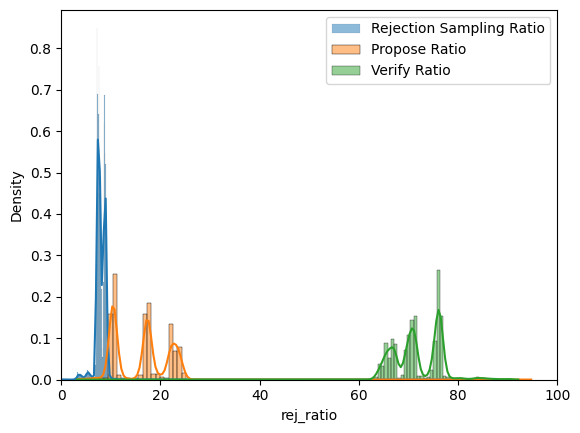

In [69]:
import seaborn as sns
sns.histplot(df['rej_ratio'], kde=True, stat="density", label='Rejection Sampling Ratio')
sns.histplot(df['propose_ratio'], kde=True, stat="density", label='Propose Ratio')
sns.histplot(df['verify_ratio'], kde=True, stat="density", label='Verify Ratio')
plt.legend()
plt.xlim(0, 100)

In [ ]:
# 2. prepare data
X = df[['num_kv_tokens', 'num_compute_tokens', 'num_spec_tokens', 'batch_size', 'enable_spec_decode']]
# X = df[['num_spec_tokens', 'batch_size']]

y = df[y_label]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=42)
X_train.head(), y_train.head()

(      num_kv_tokens  num_compute_tokens  batch_size  enable_spec_decode
 5859           8600                  92          23                True
 394            2569                  54           9                True
 4851           1291                  18           3                True
 6177           7572                  92          23                True
 8188           5557                  72          18                True,
 5859    8.246183
 394     7.437706
 4851    7.130861
 6177    8.208752
 8188    7.889509
 Name: verify_time, dtype: float64)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regressor', LinearRegression())])
6.938699571857084
[ 0.00000000e+00  4.85907942e-05  1.84383603e-02 -4.33144783e-02
  0.00000000e+00]
[16.97865397  7.17690209  9.19501162  9.53448805  8.34116297]
6253     16.992807
15302     7.221222
878       8.841753
2026      8.978605
7487      8.416653
Name: verify_time, dtype: float64
       num_kv_tokens  num_compute_tokens  batch_size  enable_spec_decode
6253            8043                 575          22                True
15302           7552                  40          20                True
878            11801                 150          25                True
2026           13246                 174          29                True
7487           11949                 108          27                True

Test R²分数 = 0.9635


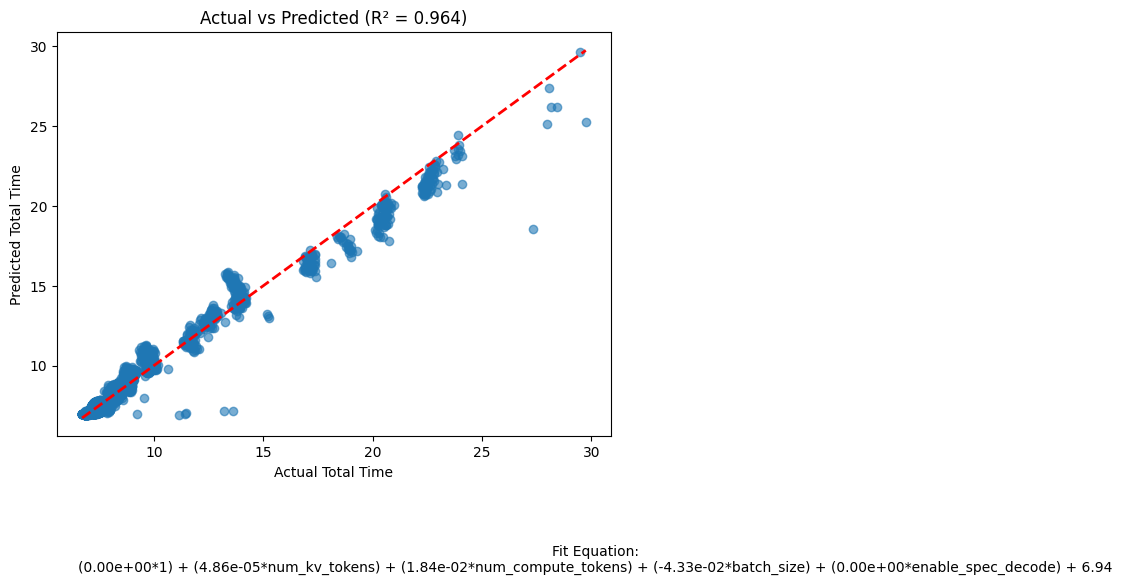

模型结构：
Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regressor', LinearRegression())])

特征名称（标准化后的多项式特征）：
['1' 'num_kv_tokens' 'num_compute_tokens' 'batch_size'
 'enable_spec_decode']

R²分数 = 0.9639


In [ ]:
from sklearn.metrics import r2_score
from joblib import dump

# model = LinearRegression(fit_intercept=True)
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                    #   ('scaler', StandardScaler()),
                      ('regressor', LinearRegression())])
model.fit(X_train, y_train)
dump(model, f'model_{y_label}.joblib')  # 保存模型


# 获取模型参数
coef = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

# 生成特征名称（包含多项式项）
# feature_names = model.named_steps['poly'].get_feature_names_out(
#     ['num_kv_tokens', 'num_compute_tokens', 'batch_size', 'enable_spec_decode']
# )
feature_names = model.named_steps['poly'].get_feature_names_out(
    ['num_kv_tokens', 'num_compute_tokens', 'num_spec_tokens', 'batch_size', 'enable_spec_decode']
)

# 生成预测值
def score(X, y):
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)
    return y_pred, r_squared

print(model)
print(intercept)
print(coef)
y_test_pred, r_test_squared = score(X_test, y_test)
print(y_test_pred[:5])
print(y_test[:5])
print(X_test[:5])
print(f"\nTest R²分数 = {r_test_squared:.4f}")
    

# 3. 可视化结果
plt.figure(figsize=(12, 5))
y_pred, r_squared = score(X_train, y_train)
plt.subplot(1, 2, 1)
if 'num_spec_tokens' in X_train.columns:
    plt.scatter(y_train, y_pred, alpha=0.6, color=X_train['num_spec_tokens'].map({ 1: 'green',
        3: 'blue', 5: 'orange', 7: 'red' }))
else:
    plt.scatter(y_train, y_pred, alpha=0.6)
                                                   
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Total Time')
plt.ylabel('Predicted Total Time')
plt.title(f'Actual vs Predicted (R² = {r_squared:.3f})')


plt.tight_layout()

# 显示拟合方程（简略版）
equation = "Fit Equation:\n"
equation += " + ".join([f"({c:.2e}*{name})" for c, name in zip(coef, feature_names)])
equation += f" + {intercept:.2f}"
plt.figtext(0.5, -0.15, equation, ha='center', fontsize=10, wrap=True)

plt.show()

# 打印模型信息
print("模型结构：")
print(model)
print("\n特征名称（标准化后的多项式特征）：")
print(feature_names)
print(f"\nR²分数 = {r_squared:.4f}")

In [5]:
goodput_data = []
with open('goodput') as f: 
    for line in f:
        entry = json.loads(line)
        goodput_data.append({
            "measured_goodput": entry['measured_goodput'],
            "num_kv_tokens": entry['num_kv_tokens'],
            "num_compute_tokens": entry['num_compute_tokens'],
            "batch_size": entry['batch_size'],
            "enable_spec_decode": entry['num_compute_tokens'] != entry['batch_size'],
            "predicted_goodput": entry['predicted_goodput'],
            "measured_time": entry['measured_time'],
            "prediced_time": entry['predicted_time'],
        })
df_goodput = pd.DataFrame(goodput_data)
df_goodput.head()

,measured_goodput,num_kv_tokens,num_compute_tokens,batch_size,enable_spec_decode,predicted_goodput,measured_time,prediced_time
0,36.338546,13,13,1,True,47.776091,27.518988,20.930972
1,35.172361,13,13,1,True,47.776091,28.431416,20.930972
2,36.072897,13,13,1,True,47.776091,27.721643,20.930972
3,36.049954,13,13,1,True,47.776091,27.739286,20.930972
4,52.825653,14,1,1,False,49.766999,18.930197,20.093637


<Axes: xlabel='num_compute_tokens', ylabel='measured_time'>

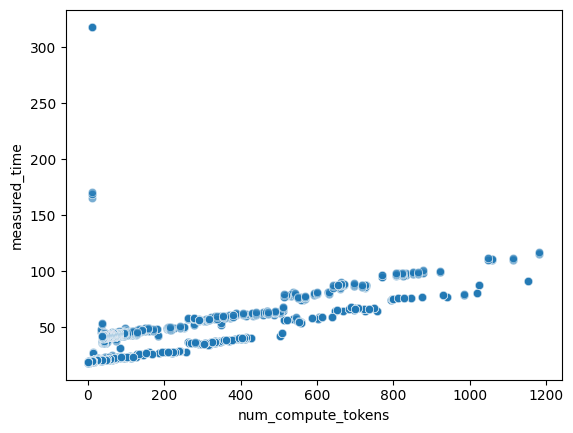

In [27]:
import seaborn as sns
sns.scatterplot(x=df_goodput['num_compute_tokens'], y=df_goodput['measured_time'], alpha=0.6)  # alpha控制点透明度

In [28]:
sns.scatterplot(x=df_goodput['measured_time'], y=df_goodput['predicted_time'], alpha=0.6)  # alpha控制点透明度

KeyError: 'predicted_time'